In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

# First Dataset: "games_details.csv"

Have a look to the Datasets, one at a time. Firstly, "games_details.csv".

In [2]:
games_details = pd.read_csv('../dataset/games_details.csv', low_memory=False)
games_details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [3]:
# ratio_missing_values prints the percentage of missing values in the column
key1 = 'COMMENT'
ratio_missing_values_column(games_details, key1)

key2 = 'START_POSITION'
ratio_missing_values_column(games_details, key2)

83.59491376370717% of the values of the column COMMENT are missing.
61.7477880076814% of the values of the column START_POSITION are missing.


0.617477880076814

'COMMENT': Since the number of valid values is very little wrt the size of the Dataset and there are not clear solutions to fill empty cells, we drop it.

'START_POSITION': same thing.

Moreover, we drop all the columns we think could lead to information leakage and also all columns that we think are not useful in the training model, such as the Nickname of the player. Our cleaned Dataset is the following

In [4]:
columns_to_drop = ['MIN','COMMENT', 'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'TEAM_CITY', 'TEAM_ABBREVIATION', 'FGA', 'FG_PCT', 'FGM', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']
games_details = games_details.drop(columns = columns_to_drop) # se non conta, si toglie. Altrimenti
# modificarla cambia il risultato

games_details.info()
games_details.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668628 entries, 0 to 668627
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   GAME_ID    668628 non-null  int64  
 1   TEAM_ID    668628 non-null  int64  
 2   PLAYER_ID  668628 non-null  int64  
 3   FG3M       558938 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 20.4 MB


,GAME_ID,TEAM_ID,PLAYER_ID,FG3M
0,22200477,1610612759,1629641,0.0
1,22200477,1610612759,1631110,2.0
2,22200477,1610612759,1627751,0.0
3,22200477,1610612759,1630170,1.0
4,22200477,1610612759,1630200,1.0


# Second Dataset: "games.csv"

Now, pass to the second Dataset, which is "games.csv".

In [5]:
games = pd.read_csv('../dataset/games.csv')
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [6]:
print(games[games['GAME_STATUS_TEXT']=='Final'].equals(games)) # so no useful information, Final is the content of each cell
games = games.drop(columns=['GAME_STATUS_TEXT'])

True


In [7]:
games_details = complete_games_details(games_details, games)

games_details['TEAM_ID'].astype(str)
games_details['OPPOSING_TEAM_ID'].astype(str) # trasformare in stringhe nome così  da non lavorare
# con numeri enormi vicini ma usare l'encoder e pace

ratio_missing_values_df(games_details) # print percentage of rows in which there is at least one
# missing value
games_details = games_details.dropna() # drop all the rows with nans
games_details = games_details.reset_index(drop=True) # adjust the indexing

games_details.head()

16.405235796287325%


,GAME_ID,TEAM_ID,PLAYER_ID,FG3M,OPPOSING_TEAM_ID,LOCATION,SEASON
0,22200477,1610612759,1629641,0.0,1610612740,Away,2022
1,22200477,1610612759,1631110,2.0,1610612740,Away,2022
2,22200477,1610612759,1627751,0.0,1610612740,Away,2022
3,22200477,1610612759,1630170,1.0,1610612740,Away,2022
4,22200477,1610612759,1630200,1.0,1610612740,Away,2022


# *Nota*:
Quando il dataset è incompleto, le funzioni che ho scritto non vanno correttamente perché è possibile che droppando le righe si perdano informazioni che permettono di collegare un dataset all'altro. Ci sono quindi molti missing values

# Third Dataset: "ranking.csv"
Aggiungere solo ultima partita della squadra avversaria e di quella del giocatore

In [8]:
ranking = pd.read_csv('../dataset/ranking.csv')
ranking.info()
ranking = ranking.drop(columns=['LEAGUE_ID', 'RETURNTOPLAY']) # se soli zeri/NaN: rimosse
ranking.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210342 entries, 0 to 210341
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TEAM_ID        210342 non-null  int64  
 1   LEAGUE_ID      210342 non-null  int64  
 2   SEASON_ID      210342 non-null  int64  
 3   STANDINGSDATE  210342 non-null  object 
 4   CONFERENCE     210342 non-null  object 
 5   TEAM           210342 non-null  object 
 6   G              210342 non-null  int64  
 7   W              210342 non-null  int64  
 8   L              210342 non-null  int64  
 9   W_PCT          210342 non-null  float64
 10  HOME_RECORD    210342 non-null  object 
 11  ROAD_RECORD    210342 non-null  object 
 12  RETURNTOPLAY   3990 non-null    float64
dtypes: float64(2), int64(6), object(5)
memory usage: 20.9+ MB


,TEAM_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD
0,1610612743,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8
1,1610612763,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9
2,1610612740,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8
3,1610612756,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9
4,1610612746,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7


# Fourth Dataset: "teams.csv"

In [9]:
teams = pd.read_csv('../dataset/teams.csv')
teams.info()
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LEAGUE_ID           30 non-null     int64  
 1   TEAM_ID             30 non-null     int64  
 2   MIN_YEAR            30 non-null     int64  
 3   MAX_YEAR            30 non-null     int64  
 4   ABBREVIATION        30 non-null     object 
 5   NICKNAME            30 non-null     object 
 6   YEARFOUNDED         30 non-null     int64  
 7   CITY                30 non-null     object 
 8   ARENA               30 non-null     object 
 9   ARENACAPACITY       26 non-null     float64
 10  OWNER               30 non-null     object 
 11  GENERALMANAGER      30 non-null     object 
 12  HEADCOACH           30 non-null     object 
 13  DLEAGUEAFFILIATION  30 non-null     object 
dtypes: float64(1), int64(5), object(8)
memory usage: 3.4+ KB


,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [10]:
teams = teams.drop(columns=['LEAGUE_ID', 'MAX_YEAR']) # max year: 2019

Looking the Dataset we can notice that some arena capacity values are missing. We've decided to fill it searching the values on google:\
-Smoothie King Center: 17,805 seats;\
-Barclays Center: 17.732 seats;\
-Wells Fargo Center: 20,318 seats;\
-Talking Stick Resort Arena: 17,071 seats;

Moreover, Amway Center capcity seems to be wrong because its value is 0. So, we correct it:\
-Amway Center: 18,846 seats

In [11]:
teams.loc[2, 'ARENACAPACITY'] = 17805.0
teams.loc[12, 'ARENACAPACITY'] = 17732.0
teams.loc[14, 'ARENACAPACITY'] = 18846.0
teams.loc[16, 'ARENACAPACITY'] = 20318.0
teams.loc[17, 'ARENACAPACITY'] = 17071.0

# Fifth Dataset: 'players.csv'

In [12]:
players = pd.read_csv('../dataset/players.csv')
players.info()
players

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7228 entries, 0 to 7227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLAYER_NAME  7228 non-null   object
 1   TEAM_ID      7228 non-null   int64 
 2   PLAYER_ID    7228 non-null   int64 
 3   SEASON       7228 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 226.0+ KB


,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019
1,Bojan Bogdanovic,1610612762,202711,2019
2,Rudy Gobert,1610612762,203497,2019
3,Donovan Mitchell,1610612762,1628378,2019
4,Mike Conley,1610612762,201144,2019
...,...,...,...,...
7223,Lanny Smith,1610612758,201831,2009
7224,Warren Carter,1610612752,201999,2009
7225,Bennet Davis,1610612751,201834,2009
7226,Brian Hamilton,1610612751,201646,2009


# Learning phase

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

We will evaluate the performance of the regression algorithms via k-fold cross-validation.
Before doing that, we choose hyperparameters by means of hyperparameter tuning (quelli su RF sono in realtà più o meno inutili perché si sa già la tendenza al variare di $n_{trees}$ e si ha già la $p$ ottimale. Ma già che c'eravamo...)

To understand the importance of each variable during the decision process, Gini importance is not as effective as feature ablation. Yet the latter is not implemented in scikit-learn, therefore we use Gini as measurement of the importance of variables.

In [14]:
games_details = games_details.drop(columns=['GAME_ID'])
games_details = games_details.sample(frac=0.05)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])

In [15]:
num_folds = 8

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'n_estimators': [50, 100, 500],
    'max_features': ['sqrt', 'log2', p] 
}

rf_regressor = RandomForestRegressor()
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 2, 'n_estimators': 500}


In [16]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
gini_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = rf_best_params['n_estimators'], max_features = rf_best_params['max_features'])
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse]

    importances = rf_regressor.feature_importances_
    gini_importances.loc[fold] = importances

In [17]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse]

In [18]:
knn_param_grid = {
    'n_neighbors': [1, 5, 10],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 10, 'p': 1}


In [19]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse]

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 5],
    'gamma': [0.01, 0.1, 1]
}

sv_regressor = SVR()

grid_search_svm = GridSearchCV(sv_regressor, svm_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search_svm.fit(X_scaled, y)

svm_best_params = grid_search_svm.best_params_
print(svm_best_params)

In [ ]:
sv_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in sv_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    sv_regressor = SVR(C = svm_best_params['C'], gamma = svm_best_params['gamma'])
    sv_regressor.fit(X_train, y_train)
    
    y_pred = sv_regressor.predict(X_test)
    
    current_sv_mae = mean_absolute_error(y_test, y_pred)
    current_sv_mse = mean_squared_error(y_test, y_pred)
    
    reg_metrics.loc[len(reg_metrics)] = ['SVM', current_sv_mae, current_sv_mse]

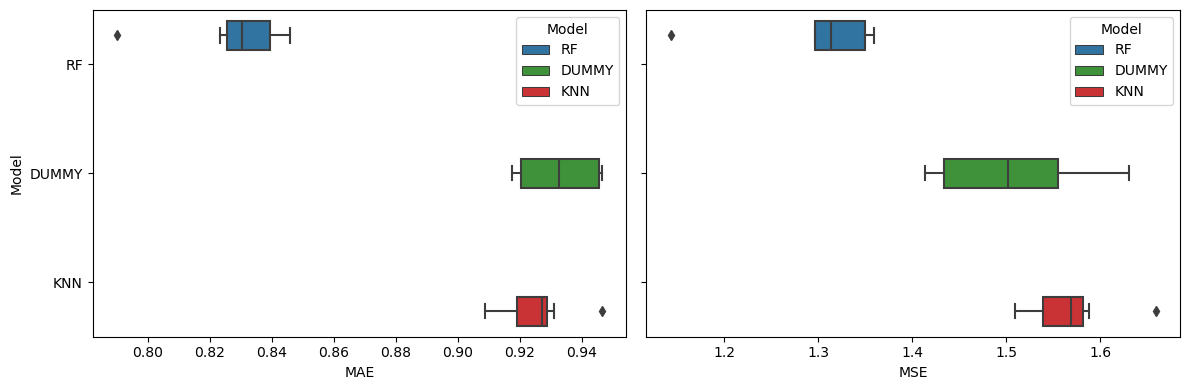

In [21]:
print(reg_metrics)
fig, axs = plt.subplots(1, 2, figsize= (12, 4))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", hue = 'Model', ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", hue = 'Model', ax=axs[1], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

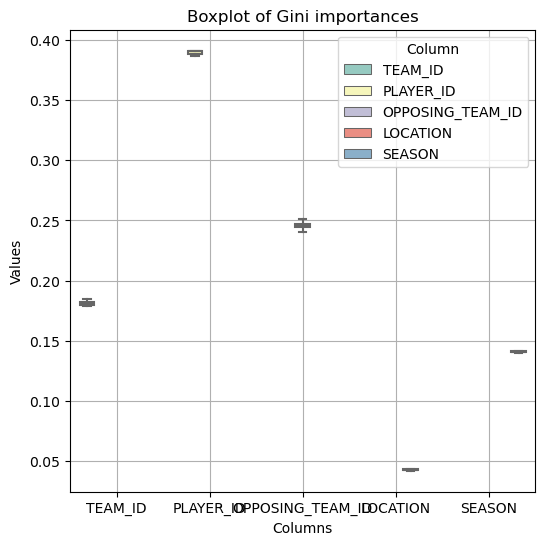

In [23]:
print(gini_importances)
melted_gini = gini_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Column', y='value', data=melted_gini, hue='Column', palette='Set3')

plt.title('Boxplot of Gini importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()